In [1]:
import pandas as pd
import numpy as np
import uuid
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
sns.set_style("ticks")

Olist conducted an experiment to see if altering the delivery estimation could result in higher review scores.

# Generate random data for A/B testing

In [2]:
date_range = pd.date_range(start="2018-07-01", end="2018-09-01")

In [3]:
date_range

DatetimeIndex(['2018-07-01', '2018-07-02', '2018-07-03', '2018-07-04',
               '2018-07-05', '2018-07-06', '2018-07-07', '2018-07-08',
               '2018-07-09', '2018-07-10', '2018-07-11', '2018-07-12',
               '2018-07-13', '2018-07-14', '2018-07-15', '2018-07-16',
               '2018-07-17', '2018-07-18', '2018-07-19', '2018-07-20',
               '2018-07-21', '2018-07-22', '2018-07-23', '2018-07-24',
               '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-28',
               '2018-07-29', '2018-07-30', '2018-07-31', '2018-08-01',
               '2018-08-02', '2018-08-03', '2018-08-04', '2018-08-05',
               '2018-08-06', '2018-08-07', '2018-08-08', '2018-08-09',
               '2018-08-10', '2018-08-11', '2018-08-12', '2018-08-13',
               '2018-08-14', '2018-08-15', '2018-08-16', '2018-08-17',
               '2018-08-18', '2018-08-19', '2018-08-20', '2018-08-21',
               '2018-08-22', '2018-08-23', '2018-08-24', '2018-08-25',
      

In [4]:
np.datetime64("2018-07-15")

numpy.datetime64('2018-07-15')

In [5]:
control = {1: 10,
           2: 3,
           3: 8,
           4: 20,
           5: 59}

test = {1: 10,
        2: 2,
        3: 10,
        4: 22,
        5: 63}

def generate_review_distribution(freq_dict):
    l = []
    for key, value in freq_dict.items():
        l += [key] * value
    return l

In [6]:
def get_random_review(date, group):
    if (group == 102) & (date >= np.datetime64("2018-07-15")):
        random_reviews = generate_review_distribution(test)
    else:
        random_reviews = generate_review_distribution(control)
    return random.choice(random_reviews)
    
def generate_random_observation(date, group):
    return str(uuid.uuid4()), get_random_review(date, group)

In [7]:
# create list of dicts to later on convert to a dataframe
rows = []
for date in date_range:
    # two groups
    for group in [101,102]:
        # pick a random number of orders btw 350 and 450
        orders = random.choice(range(350,450))
        for obs in range(orders):
            order_id, review_score = generate_random_observation(date, group)
            rows.append({"date_id": date,
                         "experiment_id": group,
                         "order_id": order_id,
                         "review_score": review_score})
            
df = pd.DataFrame(rows)

### Plot data and calculate means

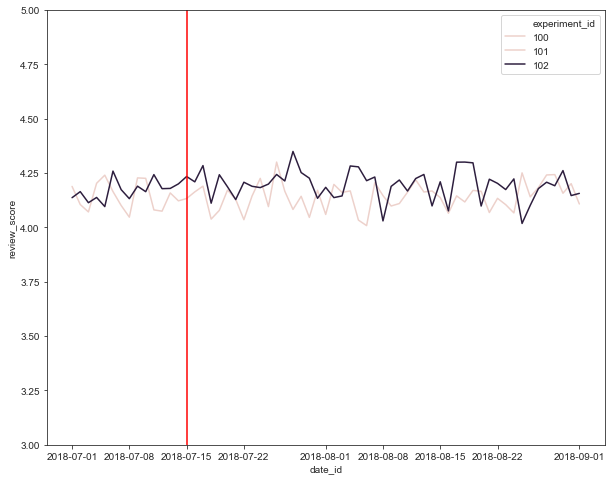

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(data=df.groupby(["date_id", "experiment_id"]).mean().reset_index(),
             x="date_id",
             y="review_score",
             hue="experiment_id",
             ax=ax);
ax.axvline("2018-07-15", color="r")
ax.set_ylim(3,5);

In [9]:
df[df["date_id"] > "2018-07-15"].groupby("experiment_id").mean()

,review_score
experiment_id,
101,4.141430
102,4.194491


In [10]:
##df.to_csv("olist_experiment_data.csv")

How do we know if this difference did not just occure by chance?
We have uncertainty because we are looking at a sample and want to generalize to all users.


We use statistics => t-test

Use the Welch's t-test (two independent samples, unequal sample sizes, unequal variance (Heteroskedasticity))

In [19]:
group_a = df.loc[df["experiment_id"] == 101, "review_score"]
group_b = df.loc[df["experiment_id"] == 102, "review_score"]

t, p = scipy.stats.ttest_ind(group_a, group_b, equal_var=False)

In [25]:
print(f"the p-value is {round(p * 100, 3)}%")

the p-value is 0.002%


### What the $(@! is the p-value?

# Central Limit Theorem


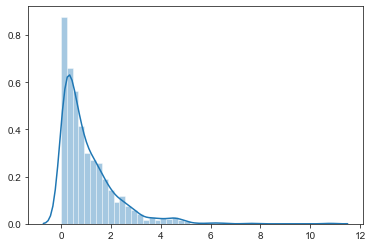

In [27]:
sns.distplot(np.random.exponential(size=1000));

In [38]:
sample_1 = np.random.exponential(size=1000) * 100

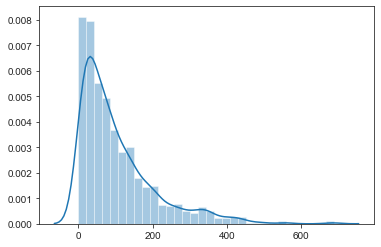

In [39]:
sns.distplot(sample_1)

In [41]:
sample_1.mean()

103.52577018253984

In [42]:
sample_2 = np.random.exponential(size=1000) * 100
sample_2.mean()

99.11121552925978

In [43]:
sample_3 = np.random.exponential(size=1000) * 100
sample_3.mean()

104.94795977316247

In [56]:
def plot_hist(n_samples, sample_size, ax):
    sample_means = [(np.random.exponential(size=sample_size) * 100).mean() for i in range(n_samples)]
    sns.distplot(sample_means, ax=ax)

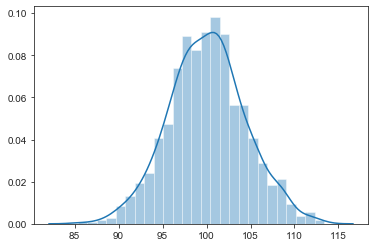

In [55]:
plot_hist(n_samples=1000, sample_size=500)

Tweak the sample size parameter and check its influence on the shape

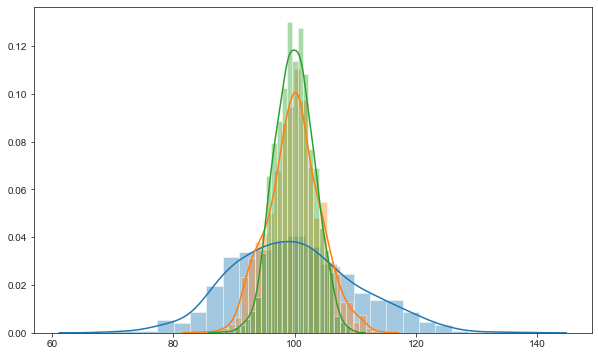

In [57]:
fig, ax = plt.subplots(figsize=(10,6))

plot_hist(n_samples=1000, sample_size=100, ax=ax)
plot_hist(n_samples=1000, sample_size=500, ax=ax)
plot_hist(n_samples=1000, sample_size=1000, ax=ax)

Tweak the number of samples you are taking and check its influence on the shape

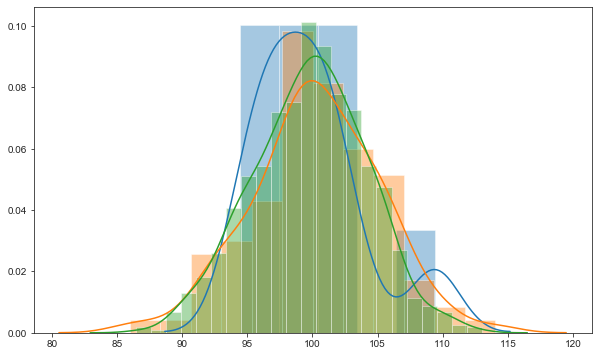

In [64]:
fig, ax = plt.subplots(figsize=(10,6))

plot_hist(n_samples=10, sample_size=500, ax=ax)
plot_hist(n_samples=100, sample_size=500, ax=ax)
plot_hist(n_samples=1000, sample_size=500, ax=ax)

# Analysis

Testing the hypothesis:

Nullhypothesis:

$H_0 : avg\_score_{control} = avg\_score_{test}$

$<=> H_0 : avg\_score_{control} - avg\_score_{test} = 0$

Against the alternative hypothesis:

$H_1 : avg\_score_{control} - avg\_score_{test} \neq 0$

-> The treatment had a non-zero impact: The overestimationg of delivery_days had an impact on review_score

In [66]:
df.head()

,date_id,experiment_id,order_id,review_score
0,2018-07-01,101,be5ed05c-5ad6-4c26-bcb4-0831c2652376,1
1,2018-07-01,101,c75a4345-6d43-43fd-8a6d-c678974ba2b6,5
2,2018-07-01,101,2a9d19b6-5382-4453-8174-7fd95782c22f,4
3,2018-07-01,101,8101fbc9-0199-44b6-a7fc-8b1c8eadccb0,5
4,2018-07-01,101,2c908f51-cc2e-45c5-8b1b-de5715d32774,3


In [65]:
df.dtypes

date_id          datetime64[ns]
experiment_id             int64
order_id                 object
review_score              int64
dtype: object

In [68]:
df_exp = df[df["date_id"] >= "2018-07-15"].copy()

In [70]:
means = df_exp.groupby("experiment_id").mean()
means

,review_score
experiment_id,
101,4.141261
102,4.195301


In [73]:
var = df_exp.groupby("experiment_id").var()
var

,review_score
experiment_id,
101,1.692226
102,1.514357


In [74]:
stds = df_exp.groupby("experiment_id").std()
stds

,review_score
experiment_id,
101,1.300856
102,1.230592


In [76]:
ssizes = df_exp.groupby("experiment_id").size()
ssizes

experiment_id
101    19694
102    19534
dtype: int64

In [78]:
np.linspace(4.1, 4.3)

array([4.1       , 4.10408163, 4.10816327, 4.1122449 , 4.11632653,
       4.12040816, 4.1244898 , 4.12857143, 4.13265306, 4.13673469,
       4.14081633, 4.14489796, 4.14897959, 4.15306122, 4.15714286,
       4.16122449, 4.16530612, 4.16938776, 4.17346939, 4.17755102,
       4.18163265, 4.18571429, 4.18979592, 4.19387755, 4.19795918,
       4.20204082, 4.20612245, 4.21020408, 4.21428571, 4.21836735,
       4.22244898, 4.22653061, 4.23061224, 4.23469388, 4.23877551,
       4.24285714, 4.24693878, 4.25102041, 4.25510204, 4.25918367,
       4.26326531, 4.26734694, 4.27142857, 4.2755102 , 4.27959184,
       4.28367347, 4.2877551 , 4.29183673, 4.29591837, 4.3       ])

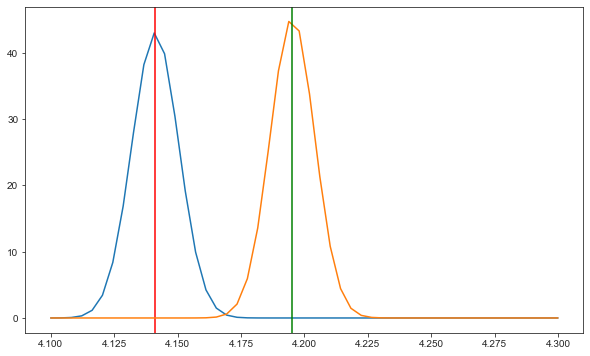

In [90]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(4.1, 4.3)

std_a = stds.loc[101, "review_score"] / np.sqrt(ssizes[101])
pdf_a = scipy.stats.norm.pdf(x,
                             means.loc[101, "review_score"],
                             std_a)

plt.plot(x, pdf_a);
ax.axvline(means.loc[101, "review_score"], color="r");

std_b = stds.loc[102, "review_score"] / np.sqrt(ssizes[102])
pdf_b = scipy.stats.norm.pdf(x,
                             means.loc[102, "review_score"],
                             std_b)

plt.plot(x, pdf_b);
ax.axvline(means.loc[102, "review_score"], color="g");